In [1]:
from dtuprosys.chemometrics.datasets import load_train_data
import matplotlib.pyplot as plt

from chemotools.derivative import SavitzkyGolay
from chemotools.scatter import MultiplicativeScatterCorrection, StandardNormalVariate
from chemotools.smooth import SavitzkyGolayFilter

In [2]:
spectra, hplc = load_train_data()
spectra = spectra.loc[:, 950:1400]

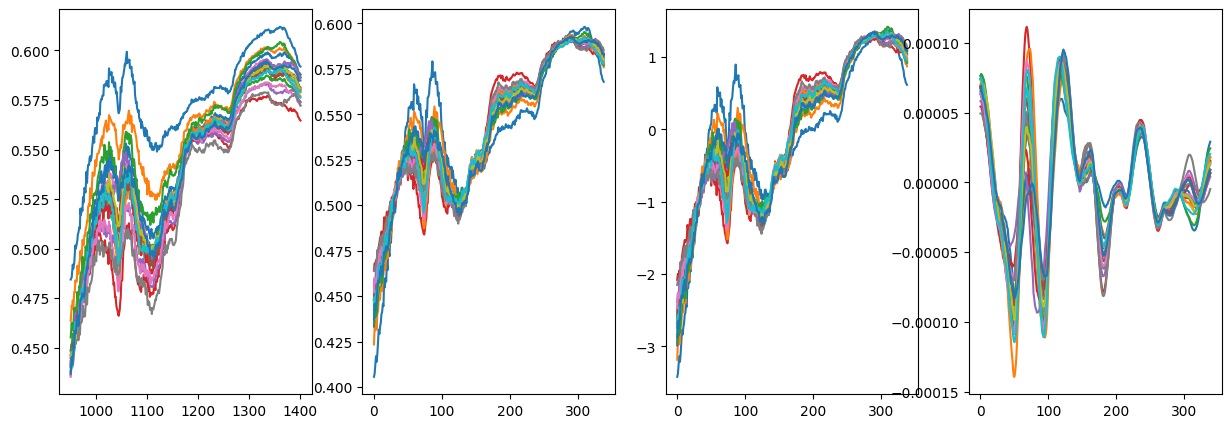

In [3]:
msc = MultiplicativeScatterCorrection(use_mean=True, use_median=False)
snv = StandardNormalVariate()
sg = SavitzkyGolay(window_size=51, polynomial_order=2, derivate_order=2, mode="nearest")

spectra_msc = msc.fit_transform(spectra)
spectra_snv = snv.fit_transform(spectra)
spectra_sg = sg.fit_transform(spectra)

fig, ax = plt.subplots(1, 4, figsize=(15, 5))
ax[0].plot(spectra.T)
ax[1].plot(spectra_msc.T)
ax[2].plot(spectra_snv.T)
ax[3].plot(spectra_sg.T)
plt.show()


In [4]:
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_is_fitted

from chemotools.utils.check_inputs import check_input


class TwoPointDriftCorrection(BaseEstimator, TransformerMixin):

    def _drift_correct_spectrum(self, x: np.ndarray) -> np.ndarray:

        # Drift correct the spectrum based on the rubber band method
        # Can take any array and returns it drift corrected
        # Find the x values at the edges of the spectrum
        y1: float = x[0]
        y2: float = x[-1]

        # Find the max and min wavenumebrs
        x1 = 0
        x2 = len(x)
        x_range = np.linspace(x1, x2, x2)

        # Calculate the straight line initial and end point
        slope = (y2 - y1) / (x2 - x1)
        intercept = y1 - slope * x1
        drift_correction = slope * x_range + intercept

        # Return the drift corrected spectrum
        return x - drift_correction

    def fit(self, X: np.ndarray, y=None) -> "TwoPointDriftCorrection":
        # Check that X is a 2D array and has only finite values
        X = check_input(X)

        # Set the number of features
        self.n_features_in_ = X.shape[1]

        # Set the fitted attribute to True
        self._is_fitted = True

        return self

    def transform(self, X: np.ndarray, y=0, copy=True) -> np.ndarray:
        # Check that the estimator is fitted
        check_is_fitted(self, "_is_fitted")

        # Check that X is a 2D array and has only finite values
        X = check_input(X)
        X_ = X.copy()

        # Check that the number of features is the same as the fitted data
        if X_.shape[1] != self.n_features_in_:
            raise ValueError(f"Expected {self.n_features_in_} features but got {X_.shape[1]}")

        # Calculate non-negative values
        for i, x in enumerate(X_):
            X_[i, :] = self._drift_correct_spectrum(x)
        return X_.reshape(-1, 1) if X_.ndim == 1 else X_

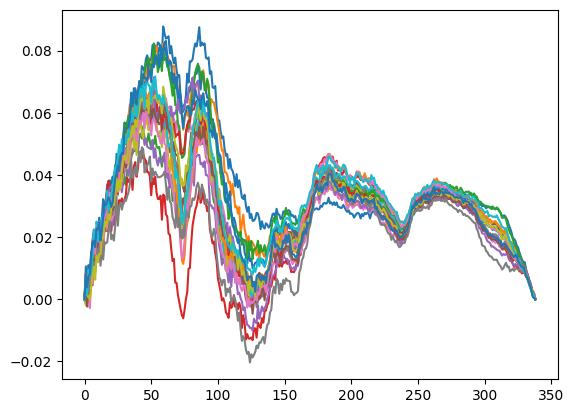

In [5]:
drift_corrected = TwoPointDriftCorrection().fit_transform(spectra)
plt.plot(drift_corrected.T)

In [14]:
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_is_fitted

from chemotools.utils.check_inputs import check_input

class PolynomialCorrection(BaseEstimator, TransformerMixin):

    def __init__(self, order, indices) -> None:
        self.order = order
        self.indices = indices

    def fit(self, X: np.ndarray, y=None) -> "TwoPointDriftCorrection":
        # Check that X is a 2D array and has only finite values
        X = check_input(X)

        # Set the number of features
        self.n_features_in_ = X.shape[1]

        # Set the fitted attribute to True
        self._is_fitted = True

        return self
    
    def transform(self, X: np.ndarray, y=0, copy=True) -> np.ndarray:
        # Check that the estimator is fitted
        check_is_fitted(self, "_is_fitted")

        # Check that X is a 2D array and has only finite values
        X = check_input(X)
        X_ = X.copy()

        # Check that the number of features is the same as the fitted data
        if X_.shape[1] != self.n_features_in_:
            raise ValueError(f"Expected {self.n_features_in_} features but got {X_.shape[1]}")

        # Calculate non-negative values
        for i, x in enumerate(X_):
            X_[i] = self._baseline_correct_spectrum(x)
        return X_.reshape(-1, 1) if X_.ndim == 1 else X_
    
    def _baseline_correct_spectrum(self, x: np.ndarray) -> np.ndarray:
        intensity = x[list(self.indices)]
        poly = np.polyfit(self.indices, intensity, self.order)
        baseline = [np.polyval(poly, i) for i in range(0, len(x))]      
        return baseline

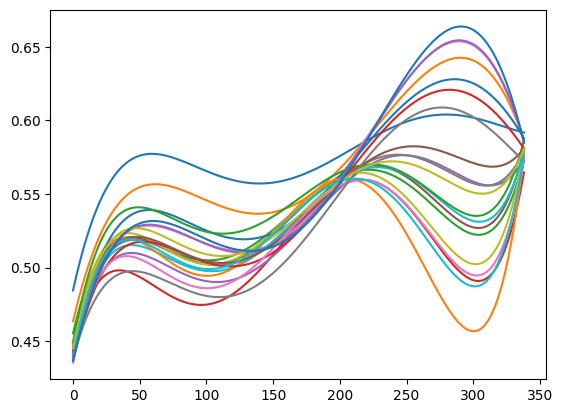

In [15]:
drift_corrected = PolynomialCorrection(5, (0, 50, 75, 100, 125, 150, 200, 338)).fit_transform(spectra)
plt.plot(drift_corrected.T)

In [10]:
import numpy as np
from scipy.interpolate import UnivariateSpline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_is_fitted

from chemotools.utils.check_inputs import check_input

class SplineCorrection(BaseEstimator, TransformerMixin):
    def __init__(self, order: int = 1, indices: tuple = (0, -1)) -> None:
        self.order = order
        self.indices = indices

    def fit(self, X: np.ndarray, y=None) -> "PolynomialCorrection":
        # Check that X is a 2D array and has only finite values
        X = check_input(X)

        # Set the number of features
        self.n_features_in_ = X.shape[1]

        # Set the fitted attribute to True
        self._is_fitted = True

        return self

    def transform(self, X: np.ndarray, y=None, copy=True):
        # Check that the estimator is fitted
        check_is_fitted(self, "_is_fitted")

        # Check that X is a 2D array and has only finite values
        X = check_input(X)
        X_ = X.copy()

        # Check that the number of features is the same as the fitted data
        if X_.shape[1] != self.n_features_in_:
            raise ValueError(f"Expected {self.n_features_in_} features but got {X_.shape[1]}")

        # Calculate spline baseline correction
        for i, x in enumerate(X_):
            X_[i] = self._spline_baseline_correct(x)
        return X_.reshape(-1, 1) if X_.ndim == 1 else X_

    def _spline_baseline_correct(self, x: np.ndarray) -> np.ndarray:
        indices = list(self.indices)
        intensity = x[indices]
        spl = UnivariateSpline(indices, intensity, k=self.order)
        baseline = spl(range(len(x)))      
        return baseline

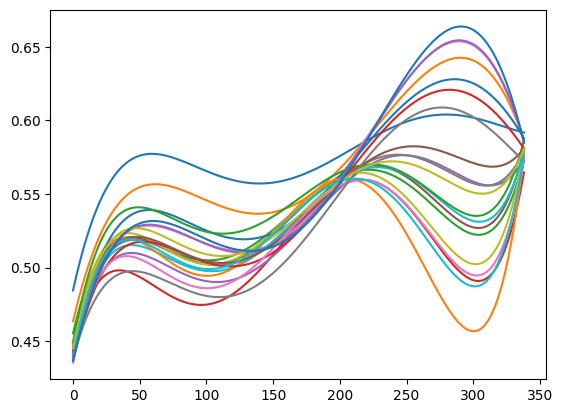

In [13]:
drift_corrected = SplineCorrection(5, (0, 50, 75, 100, 125, 150, 200, 338)).fit_transform(spectra)
plt.plot(drift_corrected.T)